# Stocks predictor Report

## Deep Learning predictor to stocks - Udacity Capstone

## Introduction

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.

This project is a web app stock price predictor that takes daily trading data as input and outputs projected close price estimates for given number of days ahead.

Manage to predict future stock close is a efficient tool in order to safely allocate or reach high incomes. Once we have lots of stock data and computation power to apply a Deep Learning model to this problem. Lets build a deep model able to predict the next values based on the knowledge in history.


In [1]:
import yfinance as yf

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from  sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping


import pandas as pd
import numpy as np

In [2]:
# "^BVSP"
stock_name = "^BVSP"
window = 30
ahead = 7

In [3]:
ticker = yf.Ticker(stock_name)
df = ticker.history(period="50y")
train_set_size = int(df.shape[0]*0.7)
close_stock_serie = df['Close'].values.reshape(-1,1)

## Data

Data is provided by Yahoo finance through YFinance python library. 

Here we can see IBOVESPA (^BVSP) the main index for brazilian economy.

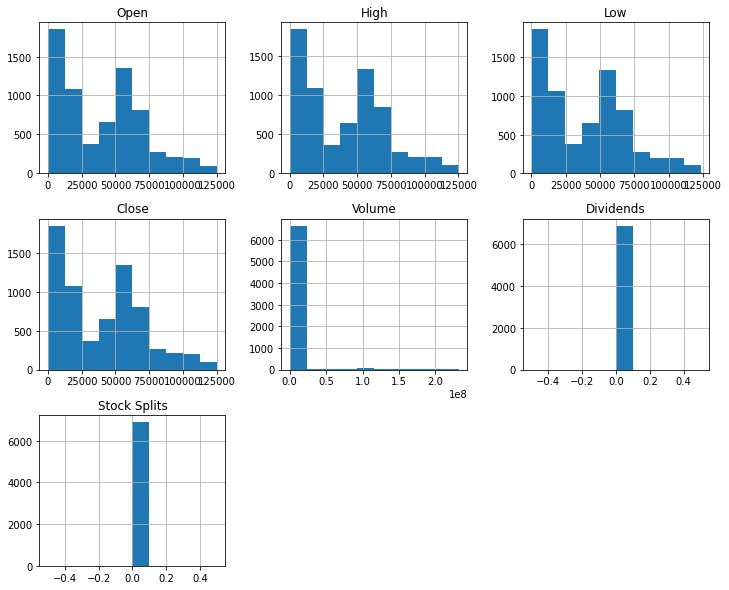

In [4]:
df.hist(figsize=[12,10]);

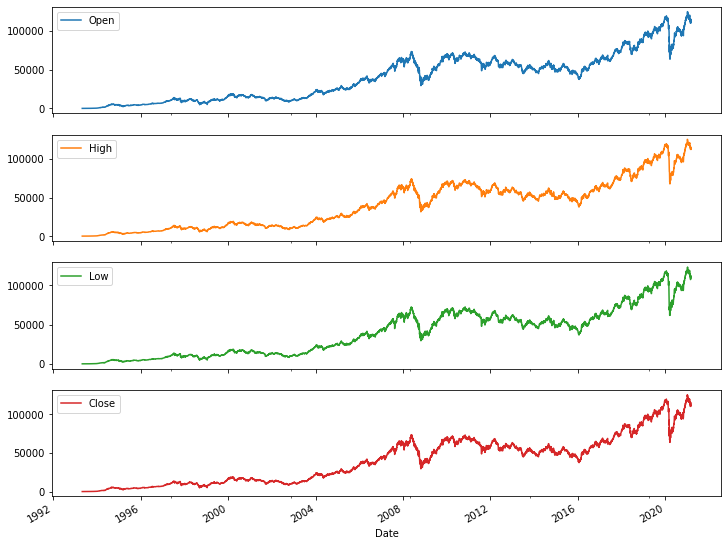

In [5]:
df.iloc[:,:4].plot(subplots=True, figsize=[12,10]);

In [6]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6891.000000,6891.000000,6891.000000,6891.000000,6.891000e+03,6891.0,6891.0
mean,40018.602316,40448.349636,39587.216177,40029.962629,5.532616e+06,0.0,0.0
std,29920.213686,30197.412220,29656.184088,29935.362049,2.082874e+07,0.0,0.0
min,23.700001,24.200001,23.700001,23.700001,0.000000e+00,0.0,0.0
25%,11693.500000,11821.000000,11545.500000,11681.000000,0.000000e+00,0.0,0.0
50%,39941.000000,40479.000000,39426.000000,39950.000000,1.113600e+06,0.0,0.0
75%,61182.500000,61904.000000,60573.500000,61177.500000,3.477050e+06,0.0,0.0
max,125075.000000,125324.000000,123227.000000,125077.000000,2.322653e+08,0.0,0.0


#### We can see our time series are very similar and bimodal and there are no missing values.

# Preprocess

At this point, we will MinMaxScale our time series beetween (0.2, 0.8)  because future values can became larger than our train set max and smaller than train set min. MinMaxScale is a required step to adapt our data set to LSTM RNN, this is compounded by a tanh activation function that requires values in (0, 1) scale to be effective.

In [7]:
sc = MinMaxScaler(feature_range = (.2, .8))
training_set_scaled = sc.fit_transform(close_stock_serie[:train_set_size])

In [8]:
def make_window(series, window, ahead):
    """
        series: a numpy time series with shape (n, 1)
        window : size of past values each step of LSTM will see
        ahead : size of future values each step of LSTM will predict
    """
    size = len(series)
    X = np.array([series[i - window:i] for i in range(window, size - ahead)])
    y = np.array([series[i + ahead] for i in range(window, size - ahead)])
    X_train = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

In [9]:
X_train, y_train = make_window(training_set_scaled, window, ahead)

## Model

The model is an LSTM that is an State of the art model to time series prediction problems, for more, see an article I wrote about LSTM vs ARIMA (wide applied time series model) https://link.springer.com/chapter/10.1007%2F978-3-030-30241-2_43

At some iterations with this model, I observed that adding Dropout regularization and a dense layer after LSTM improved our prediction and as such Earlystopping with 10 epochs of patience and adam optimizer.

In [10]:
model = Sequential()

# LSTM Layer
model.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1)))

# Regularization Layer
model.add(Dropout(0.2))

model.add(Dense(units = 10, activation='linear'))

# output Layer
model.add(Dense(units = 1, activation='linear'))

# Compile
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fit
model.fit(X_train, y_train, epochs = 200, validation_split=0.1, batch_size = 128, callbacks=[
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
])



Epoch 1/200
34/34 [==============================] - 1s 20ms/step - loss: 0.0315 - val_loss: 0.0113
Epoch 2/200
34/34 [==============================] - 0s 14ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 3/200
34/34 [==============================] - 1s 18ms/step - loss: 0.0027 - val_loss: 5.1044e-04
Epoch 4/200
34/34 [==============================] - 1s 17ms/step - loss: 0.0021 - val_loss: 6.1380e-04
Epoch 5/200
34/34 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 6.7420e-04
Epoch 6/200
34/34 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 6.1504e-04
Epoch 7/200
34/34 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 4.9893e-04
Epoch 8/200
34/34 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 5.2721e-04
Epoch 9/200
34/34 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 5.6067e-04
Epoch 10/200
34/34 [==============================] - 1s 16ms/step - los

The best model was choosen by a validation set (10%) mean squared error early stopping.

In [11]:
model.save("IBOVESPA-MODEL.h5")

## Test Set performance

In [12]:
stock_serie = df['Close']
test_set = stock_serie[-(len(close_stock_serie[train_set_size:]) + window):].values.reshape(-1,1)
test_set_scaled = sc.transform(test_set)

In [13]:
X_test, y_test = make_window(test_set_scaled, window, ahead)

In [14]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Text(0.5, 1.0, 'real x predicted test set')

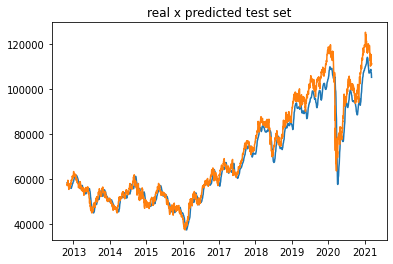

In [15]:
plt.plot(stock_serie[train_set_size + ahead:].index, predicted_stock_price)
plt.plot(stock_serie[train_set_size + ahead:]);
plt.title('real x predicted test set')

# Metrics

"It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0."

source: https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score 

In [16]:
r2_score(stock_serie[train_set_size + ahead:], predicted_stock_price)

0.9468803104391434

# Discussion

As we can see, the model achieves a good performance looking only to past values. R2 score falls above 0.9 on the test set prediction which is a good result and implies our model generalizes well as we can see by the plot real x predicted for the test set.

This model provides us one way to know next close prices and with this we have one more tool to analise stocks and consider to buy or sell a stock.

### Improvements

Some improvements should be add another data sources as news and social media sentiment.

Github
https://github.com/gabrieldiasdeabreu/Stock-Predictor-Udacity-capstone